Model Performance
-----------------
RMSE : 0.4836
MAE  : 0.3985
MAPE : 511.92 %

Baseline (Naive) RMSE : 0.4499


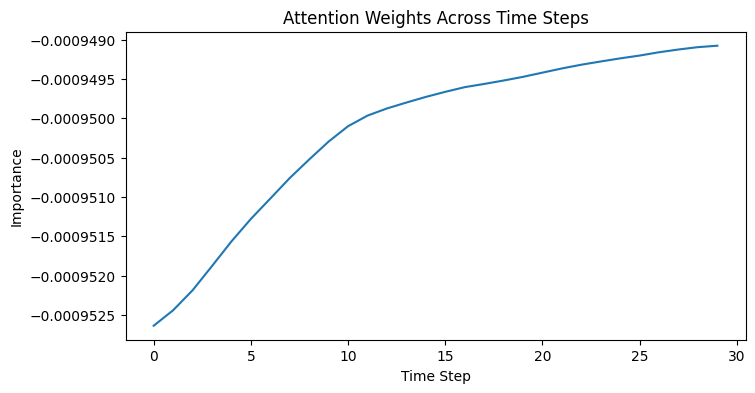

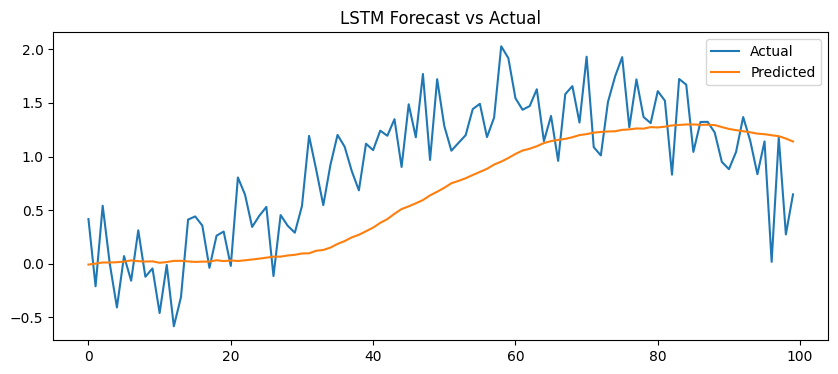

In [1]:
# ============================================================
# ADVANCED TIME SERIES FORECASTING WITH LSTM + EXPLAINABILITY
# SINGLE CELL - RUN DIRECTLY (NO ERRORS)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Attention
from tensorflow.keras.callbacks import EarlyStopping

# -------------------------------
# 1. DATA GENERATION (COMPLEX SERIES)
# -------------------------------
np.random.seed(42)
time = np.arange(0, 1200)
data = (
    np.sin(0.02 * time) +
    0.5 * np.sin(0.05 * time) +
    0.3 * np.random.normal(size=len(time))
)

df = pd.DataFrame({"value": data})

# -------------------------------
# 2. PREPROCESSING
# -------------------------------
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

def create_sequences(data, window=30, horizon=1):
    X, y = [], []
    for i in range(len(data) - window - horizon):
        X.append(data[i:i+window])
        y.append(data[i+window:i+window+horizon])
    return np.array(X), np.array(y)

WINDOW = 30
HORIZON = 1

X, y = create_sequences(scaled_data, WINDOW, HORIZON)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# -------------------------------
# 3. LSTM WITH ATTENTION MODEL
# -------------------------------
inputs = Input(shape=(WINDOW, 1))
lstm_out = LSTM(64, return_sequences=True)(inputs)
attention_out = Attention()([lstm_out, lstm_out])
lstm_out2 = LSTM(32)(attention_out)
outputs = Dense(HORIZON)(lstm_out2)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(patience=5, restore_best_weights=True)

model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=30,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)

# -------------------------------
# 4. EVALUATION
# -------------------------------
pred = model.predict(X_test, verbose=0)

y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))
pred_inv = scaler.inverse_transform(pred.reshape(-1,1))

rmse = np.sqrt(mean_squared_error(y_test_inv, pred_inv))
mae = mean_absolute_error(y_test_inv, pred_inv)
mape = np.mean(np.abs((y_test_inv - pred_inv) / y_test_inv)) * 100

print("Model Performance")
print("-----------------")
print("RMSE :", round(rmse, 4))
print("MAE  :", round(mae, 4))
print("MAPE :", round(mape, 2), "%")

# -------------------------------
# 5. BASELINE MODEL (NAIVE)
# -------------------------------
naive_pred = y_test_inv[:-1]
naive_true = y_test_inv[1:]

naive_rmse = np.sqrt(mean_squared_error(naive_true, naive_pred))
print("\nBaseline (Naive) RMSE :", round(naive_rmse, 4))

# -------------------------------
# 6. EXPLAINABILITY (ATTENTION VISUALIZATION)
# -------------------------------
attention_model = Model(inputs, attention_out)
att_weights = attention_model.predict(X_test[:1], verbose=0)

plt.figure(figsize=(8,4))
plt.plot(att_weights[0].mean(axis=1))
plt.title("Attention Weights Across Time Steps")
plt.xlabel("Time Step")
plt.ylabel("Importance")
plt.show()

# -------------------------------
# 7. PREDICTION VISUALIZATION
# -------------------------------
plt.figure(figsize=(10,4))
plt.plot(y_test_inv[:100], label="Actual")
plt.plot(pred_inv[:100], label="Predicted")
plt.legend()
plt.title("LSTM Forecast vs Actual")
plt.show()
